This notebook will run MHI with decay specified in config, with transforms on 
- MobileNet
- Resnet50
- EfficientNetB0

Dataset is 100 samples.<br>
DECAY = 0.09<br>
FRAME_SIZE = 20<br>
BINARY_THRESHOLD = 25

In [1]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer albumentations

# Config

In [1]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random
import wandb
import pandas as pd

from typing import Tuple
from collections import Counter
import albumentations as A
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf

In [2]:
class CONFIG:
    ROOT_DIRECTORY = os.path.join("..","data","WLASL")
    JSON_FILE = "WLASL_v0.3.json"
    NSLT_FILE = "nslt_100.json"
    VIDEO_FOLDER = "videos"

    mean=[0, 0, 0]
    std=[1, 1, 1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.8
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.05
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 100
    FRAME_SIZE = 20
    
    BATCH_SIZE = 4
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"
    DECAY = 0.09
    
    USE_WANDB = True

    WANDB_RUN = "MHI-CNN"

## Utils

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from wandb.keras import WandbMetricsLogger
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, run_name : str,
                train_ds, val_ds, dataset_name,
                max_lr = 1e-4, min_lr = 5e-5,
                T_max=50, epochs=100,
                decay = 0.09,USE_WANDB=True): 
   
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)

    callbacks = [checkpoint, cosine_annealer]

    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : min_lr, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : train_ds_len,
                                "val_size" : val_ds_len,
                                "unique_classes" : unique_labels_num, 
                                "video_length" : CONFIG.FRAME_SIZE,
                                "decay" : decay,
                                "SHIFT_LIMIT" : CONFIG.SHIFT_LIMIT,
                                "SCALE_LIMIT" : CONFIG.SCALE_LIMIT,
                                "ROTATE_LIMIT" : CONFIG.ROTATE_LIMIT,
                                "CACHEING" : dataset_name
                               })
        callbacks.append(WandbMetricsLogger())
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks)
    #wandb.finish()
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Cacheing Dataset definition

## Dataset definitions

In [4]:
from sklearn.model_selection import train_test_split
from math import ceil

class SignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, max_start : int, max_end) -> None:
        # setup the paths
        video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
        dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

        # load the filepaths for videos
        self.video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

        # load the dataset config json
        self.config_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
            self.config_json = json.load(f)

        # load the dataset json
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f)
        
        self.videos_paths = []
        self.paths_not_found = []
        self.labels = []
        self.start_frames = []
        self.end_frames = []
       
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f) 

        for el in tqdm(self.dataset_json.items()):
            video_id, properties = el[0], el[1]
            path = os.path.join(video_path, video_id + ".mp4")
            
            if not os.path.exists(path):
                self.paths_not_found.append(path)
                continue

            subset = properties["subset"]
            label, start, end = properties["action"]
            
            if start > max_start:
                continue
                
            if end > max_end:
                continue
            
            self.videos_paths.append(path)
            self.labels.append(label)
            self.start_frames.append(start)
            self.end_frames.append(end)
    
        self.videos_paths = np.array(self.video_paths)
        self.paths_not_found = np.array(self.paths_not_found)
        self.labels = np.array(self.labels)
        self.start_frames = np.array(self.start_frames)
        self.end_frames = np.array(self.end_frames)

        self.unique_labels = np.unique(self.labels)
        
    
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return traj
    
    def __len__(self):
        return len(self.videos_paths)

    def __getitem__(self, idx):
        path, label = self.videos_paths[idx], self.labels[idx]
        trajectory = SignRecognitionDataset.get_video(path)
        
        return self.preprocess_trajectory(trajectory), label

    def permutate(self):
        l = len(self.videos_paths)
        mask = np.arange(l)
        np.random.shuffle(mask)
        
        self.videos_paths = np.array(self.videos_paths)[mask]
        self.labels = np.array(self.labels)[mask]
        self.start_frames = np.array(self.start_frames)[mask]
        self.end_frames = np.array(self.end_frames)[mask]
        
    def sort_by_size(self):
        c = Counter(self.labels)
        _mask = sorted([ (10000 * c[l] + l, i) for i, l in enumerate(self.labels)])[::-1]
        mask_by_size = np.array([el[1] for el in _mask])

        self.video_paths        = np.array(self.video_paths)[mask_by_size]
        self.labels             = np.array(self.labels)[mask_by_size]
        self.start_frames       = np.array(self.start_frames)[mask_by_size]
        self.end_frames         = np.array(self.end_frames)[mask_by_size]

    def crop_video(self, trajectory : np.array) -> np.array:
        cropped = trajectory
        
        if self.FRAME_SIZE != 0:
            frame_size = len(trajectory)
            start = 0 
            
            if frame_size > self.FRAME_SIZE:
                start = np.random.randint(0, frame_size - self.FRAME_SIZE)
            cropped = trajectory[start: (start + self.FRAME_SIZE)]
                    
            if len(cropped) < self.FRAME_SIZE:
                necessary = self.FRAME_SIZE - len(cropped)
                t, h, w, c = trajectory.shape
                cropped = np.concatenate([cropped, np.zeros((necessary, h, w, c))], axis= 0)
                
            return cropped
                        
        return trajectory
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)
        

class SignRecognitionDatasetMHICachedV2(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, 
                 per_image_transform=None,
                 after_MHI_transform=None,
                 scaled_resolution : Tuple[int]= (224, 224),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 decay : float = 0.7,
                 threshold_method : str = "regular",
                 threshold_val : float = 25/255.,
                 by_size=True,
                 train_val_split:float=CONFIG.PORTION_OF_DATA_FOR_TRAINING,
                 split:str="train") -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.per_image_transform = per_image_transform
        self.after_MHI_transform = after_MHI_transform
        self.FRAME_SIZE = frame_size
        self.decay = decay
        self.threshold_method = threshold_method
        self.threshold_val = threshold_val
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
        self.sort_by_size()
        
        if self.DATA_LIMIT > 0:
            self.video_paths        = self.video_paths[:self.DATA_LIMIT]
            self.labels             = self.labels[:self.DATA_LIMIT]
            self.start_frames       = self.start_frames[:self.DATA_LIMIT]
            self.end_frames         = self.end_frames[:self.DATA_LIMIT]
        

        self.dataset = np.concatenate([np.array(self.video_paths).reshape(-1, 1),
                                       np.array(self.labels).reshape(-1, 1)], axis=1)   
        
        self.unique_labels = np.unique(self.dataset[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
        train_ds, val_ds = train_test_split(self.dataset, train_size=train_val_split, 
                                            random_state=42, stratify=self.dataset[:, 1])
                                                            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds
        
        else: 
            raise Exception("")

        self.cache_data()

    
    def cache_data(self):    
        self.cached_X = []
        self.cached_Y = []
        
        for i,(path, label) in tqdm(enumerate(self.dataset), desc="Cacheing"):
            trajectory = self.preprocess_trajectory(SignRecognitionDataset.get_video(path))  
            
            X_trajectory = []
            
            trajectory_length = trajectory.shape[0]
            if trajectory_length < self.FRAME_SIZE:
                X_trajectory.append(self.postprocess_trajectory(trajectory))

            else:
                for i in range(0, trajectory_length - self.FRAME_SIZE):
                    X_trajectory.append(self.postprocess_trajectory(trajectory[i: (i + self.FRAME_SIZE)]))
            
            onehotencoded = np.zeros(len(self.unique_labels))
            onehotencoded[self.label_2_id[label]] = 1.0
            
            for frame in X_trajectory:                    
                self.cached_X.append(frame)
                self.cached_Y.append(onehotencoded)
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)
        
    def __len__(self):
        return len(self.cached_X)

    def postprocess_trajectory(self, traj : np.ndarray) -> np.ndarray:
        # timeframe, Width, height, channels
        ts, w, h, c = traj.shape
        
        mhi = np.zeros((w, h))
                
        for i in range(1, ts):
            frame_diff = np.abs(traj[i] - traj[i-1])
            gray_diff = np.mean(frame_diff, axis=2)
            
            _, binary_diff = cv2.threshold(gray_diff, self.threshold_val, 1.0, cv2.THRESH_BINARY)
    
    
            mhi = mhi * (1.0 - self.decay) + binary_diff

        mhi = mhi.reshape(mhi.shape[0], mhi.shape[1], 1)
        return np.concatenate([mhi,mhi,mhi], axis=2)


    def __getitem__(self, idx):
        
        trajectory, label = self.cached_X[idx], self.cached_Y[idx]
        trajectory = self.per_image_transform(image=trajectory)["image"]

        return trajectory, label

    
    
import matplotlib.pyplot as plt 

transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        #A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        #A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
        #                   scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ]
)

train_ds = SignRecognitionDatasetMHICachedV2(1, 150, per_image_transform=transform, decay=CONFIG.DECAY, split="train")
val_ds = SignRecognitionDatasetMHICachedV2(1, 150, per_image_transform=transform, decay=CONFIG.DECAY, split="val")


train_ds_len = len(train_ds)
val_ds_len = len(val_ds)
unique_labels_num = len(train_ds.unique_labels)

print(f"size of train_ds = {len(train_ds)}, size of val_ds = {len(val_ds)}")
x, y = next(iter(train_ds))
x_shape = x.shape
y_shape = y.shape
print(x_shape, y_shape)

100%|██████████| 2038/2038 [00:00<00:00, 47976.87it/s]
Cacheing: 80it [02:35,  1.94s/it]
100%|██████████| 2038/2038 [00:00<00:00, 41448.63it/s]
Cacheing: 20it [00:29,  1.46s/it]

size of train_ds = 4489, size of val_ds = 1118
(224, 224, 3) (7,)


In [7]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_ds)):
        X_batch, Y_batch = train_ds[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_ds)):
        X_batch, Y_batch = val_ds[i]
        yield X_batch, Y_batch        

train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

In [19]:
train_labels = []
val_labels = []
nans = False

for x, y in train_dataset:
    labels = np.argmax(y, axis=1)
    for l in labels:
        train_labels.append(l)

    nans |= np.any(np.isnan(x))
print(f"nans = {nans}")        

for x, y in val_dataset:
    labels = np.argmax(y, axis=1)
    for l in labels:
        val_labels.append(l)
print(f"nans = {nans}")        

nans = False
nans = False


e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


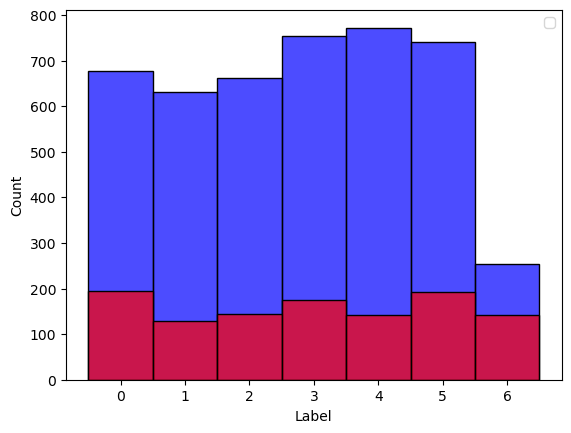

In [22]:
import seaborn as sns 

train_df_labels = pd.DataFrame(train_labels, columns=['Label'])
val_df_labels = pd.DataFrame(val_labels, columns=['Label'])


sns.histplot(train_df_labels, x="Label", alpha=0.7, discrete=True, kde=False, color="blue")
sns.histplot(val_df_labels, x="Label", alpha=0.7,discrete=True, kde=False, color="red")
plt.legend()
plt.show()

## run the experiments

### MobileNetV3

In [41]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, run_name="C2_MobileNetV3Small_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            max_lr = 1e-4, 
            min_lr = 5e-5,
            T_max=251, 
            epochs=500,
            filepath=os.path.join("models", "C2_MobileNetV3Small_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/100
     19/Unknown - 18s 37ms/step - loss: 11.1512 - categorical_accuracy: 0.1579

2024-04-15 19:00:57.922702: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6307957430542464359
2024-04-15 19:00:57.922794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9026497124938102457
2024-04-15 19:00:57.922815: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7670920061644508805


INFO:tensorflow:Assets written to: models/C2_MobileNetV3Small.tf/assets


INFO:tensorflow:Assets written to: models/C2_MobileNetV3Small.tf/assets


20/20 [==============================] - 33s 828ms/step - loss: 11.1968 - categorical_accuracy: 0.1500 - val_loss: 2.0834 - val_categorical_accuracy: 0.2000
Epoch 2/100
20/20 [==============================] - 1s 48ms/step - loss: 7.6474 - categorical_accuracy: 0.1250 - val_loss: 2.1278 - val_categorical_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - 1s 46ms/step - loss: 5.3387 - categorical_accuracy: 0.2500 - val_loss: 2.2293 - val_categorical_accuracy: 0.2000
Epoch 4/100
20/20 [==============================] - 1s 44ms/step - loss: 5.1190 - categorical_accuracy: 0.2125 - val_loss: 2.3188 - val_categorical_accuracy: 0.2000
Epoch 5/100
20/20 [==============================] - 1s 42ms/step - loss: 4.6056 - categorical_accuracy: 0.2250 - val_loss: 2.3283 - val_categorical_accuracy: 0.2000
Epoch 6/100
20/20 [==============================] - 1s 42ms/step - loss: 4.2142 - categorical_accuracy: 0.2375 - val_loss: 2.3995 - val_categorical_accuracy: 0.2000
Epoch 7/100
2

epoch/categorical_accuracy,▁▂▂▂▂▃▃▃▄▃▃▄▄▅▄▅▆▆▆▆▆▆▆▆▆▇▆█▇▆▆▇▇█▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,████▁▁▁▁████▃▁▁▁▁███████████████████████
epoch/val_loss,▁▁▂▂▂▃▃▃▂▂▂▂▅▆▅▅▅▅▅▇▆▇▆▆▇▇▇▇▅▆▆▇██▆▅▄▅▅▅
epoch/categorical_accuracy,0.875
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.33321
epoch/val_categorical_accuracy,0.2


### Resnet50

In [ ]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.ResNet50(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="C2_Resnet50_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=251, 
            epochs=500,
            max_lr = 0.75e-4, 
            min_lr = 2.5e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "MHI_Resnet50_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/500
     20/Unknown - 27s 59ms/step - loss: 2.5596 - categorical_accuracy: 0.1750

2024-04-15 19:06:44.268103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7827257057883545257
2024-04-15 19:06:44.268228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8940206431827680969


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 44s 931ms/step - loss: 2.5596 - categorical_accuracy: 0.1750 - val_loss: 2.8761 - val_categorical_accuracy: 0.2000
Epoch 2/500
20/20 [==============================] - 1s 58ms/step - loss: 2.1957 - categorical_accuracy: 0.2250 - val_loss: 2.9090 - val_categorical_accuracy: 0.2000
Epoch 3/500
20/20 [==============================] - 1s 58ms/step - loss: 2.0456 - categorical_accuracy: 0.2375 - val_loss: 2.3261 - val_categorical_accuracy: 0.2000
Epoch 4/500
20/20 [==============================] - 1s 64ms/step - loss: 2.0417 - categorical_accuracy: 0.2750 - val_loss: 2.3356 - val_categorical_accuracy: 0.2000
Epoch 5/500
20/20 [==============================] - 1s 64ms/step - loss: 1.7729 - categorical_accuracy: 0.3875 - val_loss: 4.5294 - val_categorical_accuracy: 0.2000
Epoch 6/500
20/20 [==============================] - 1s 63ms/step - loss: 1.8547 - categorical_accuracy: 0.3000 - val_loss: 4.1211 - val_categorical_accuracy: 0.2000
Epoch 7/500
20

INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 19s 1s/step - loss: 0.1563 - categorical_accuracy: 0.9625 - val_loss: 19.2733 - val_categorical_accuracy: 0.2500
Epoch 62/500
20/20 [==============================] - ETA: 0s - loss: 0.2343 - categorical_accuracy: 0.9500INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 19s 1s/step - loss: 0.2343 - categorical_accuracy: 0.9500 - val_loss: 20.3617 - val_categorical_accuracy: 0.3000
Epoch 63/500
20/20 [==============================] - 1s 59ms/step - loss: 0.2062 - categorical_accuracy: 0.9625 - val_loss: 18.3190 - val_categorical_accuracy: 0.2500
Epoch 64/500
20/20 [==============================] - 1s 59ms/step - loss: 0.0724 - categorical_accuracy: 0.9875 - val_loss: 21.3327 - val_categorical_accuracy: 0.2000
Epoch 65/500
20/20 [==============================] - 1s 59ms/step - loss: 0.0748 - categorical_accuracy: 0.9875 - val_loss: 27.8325 - val_categorical_accuracy: 0.2000
Epoch 66/500
20/20 [==============================] - 1s 60ms/step - loss: 0.1365 - categorical_accuracy: 0.9500 - val_loss: 25.7577 - val_categorical_accuracy: 0.2000
Epoch 67/500
20/20 [==============================] - 1s 63ms/step - loss: 0.1439 - categorical_accuracy: 0.9500 - val_loss: 21.3883 - val_categorical_accuracy: 0.1500
Epoch 

### EfficientNetB0

In [44]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.EfficientNetB0(input_shape = MHI_SHAPE,
                                                include_top = False,
                                                weights = 'imagenet',
                                                pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="C2_EfficientNetB0_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=501, 
            epochs=1000,
            max_lr = 1e-4, 
            min_lr = 1e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "C2_EfficientNetB0_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

epoch/categorical_accuracy,▁▃▁▅▆▄▇▅▆█▅▅▄█▅▆▇█▃
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,█████▇▇▇▆▆▆▅▅▄▄▃▂▂▁
epoch/loss,█▇▅▅▅▅▃▄▃▃▃▃▄▁▄▁▂▂▄
epoch/val_categorical_accuracy,▂▄▂▅█▂▄▄▅▄▅▂▅▄█▇▄▁▄
epoch/val_loss,▂▃▄▄▅▂▆█▇▄▅▆▄▂▂▁▄▅█
epoch/categorical_accuracy,0.1875
epoch/epoch,18
epoch/learning_rate,0.0001
epoch/loss,1.92845
epoch/val_categorical_accuracy,0.15


Epoch 1/1000
     19/Unknown - 1s 12ms/step - loss: 2.5541 - categorical_accuracy: 0.1447

2024-04-15 20:25:12.610324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3349952044877754649
2024-04-15 20:25:12.610375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14498149272523616542
2024-04-15 20:25:12.610405: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133121464649995126


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


2024-04-15 20:25:12.840681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3349952044877754649
2024-04-15 20:25:12.840769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6630784775236842777
2024-04-15 20:25:12.840846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4556428208539362992
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 2s 76ms/step - loss: 2.5875 - categorical_accuracy: 0.1375 - val_loss: 2.3158 - val_categorical_accuracy: 0.0500
Epoch 2/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0391 - categorical_accuracy: 0.1579INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 64ms/step - loss: 2.0335 - categorical_accuracy: 0.1500 - val_loss: 2.0524 - val_categorical_accuracy: 0.3000
Epoch 3/1000
20/20 [==============================] - 0s 15ms/step - loss: 2.0073 - categorical_accuracy: 0.2375 - val_loss: 2.0798 - val_categorical_accuracy: 0.1000
Epoch 4/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.8469 - categorical_accuracy: 0.3000 - val_loss: 2.2172 - val_categorical_accuracy: 0.0500
Epoch 5/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.8352 - categorical_accuracy: 0.3250 - val_loss: 2.0751 - val_categorical_accuracy: 0.2000
Epoch 6/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.7232 - categorical_accuracy: 0.2500 - val_loss: 2.2522 - val_categorical_accuracy: 0.1000
Epoch 7/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.7331 - categorical_accuracy: 0.3625 - val_loss: 2.3925 - val_categorical_accuracy: 0.1500
Epoch 8/100

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 66ms/step - loss: 1.4061 - categorical_accuracy: 0.5125 - val_loss: 1.9711 - val_categorical_accuracy: 0.3500
Epoch 65/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.5720 - categorical_accuracy: 0.4500 - val_loss: 2.4768 - val_categorical_accuracy: 0.0500
Epoch 66/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3005 - categorical_accuracy: 0.5375 - val_loss: 2.0595 - val_categorical_accuracy: 0.0500
Epoch 67/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3653 - categorical_accuracy: 0.5250 - val_loss: 2.3544 - val_categorical_accuracy: 0.1000
Epoch 68/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.4216 - categorical_accuracy: 0.5125 - val_loss: 2.3392 - val_categorical_accuracy: 0.1000
Epoch 69/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.3836 - categorical_accuracy: 0.5250 - val_loss: 2.1411 - val_categorical_accuracy: 0.1500
Epoch 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 65ms/step - loss: 1.2883 - categorical_accuracy: 0.5500 - val_loss: 1.8682 - val_categorical_accuracy: 0.4000
Epoch 224/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3855 - categorical_accuracy: 0.5375 - val_loss: 2.6614 - val_categorical_accuracy: 0.1500
Epoch 225/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2329 - categorical_accuracy: 0.6375 - val_loss: 2.2735 - val_categorical_accuracy: 0.2000
Epoch 226/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2806 - categorical_accuracy: 0.5750 - val_loss: 2.0813 - val_categorical_accuracy: 0.2500
Epoch 227/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.3486 - categorical_accuracy: 0.5375 - val_loss: 2.1293 - val_categorical_accuracy: 0.1500
Epoch 228/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2421 - categorical_accuracy: 0.6250 - val_loss: 2.1897 - val_categorical_accuracy: 0.1500
E

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 62ms/step - loss: 1.1632 - categorical_accuracy: 0.5750 - val_loss: 1.9265 - val_categorical_accuracy: 0.4500
Epoch 398/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2471 - categorical_accuracy: 0.6250 - val_loss: 2.1876 - val_categorical_accuracy: 0.2000
Epoch 399/1000
20/20 [==============================] - 0s 19ms/step - loss: 1.0265 - categorical_accuracy: 0.6500 - val_loss: 2.2331 - val_categorical_accuracy: 0.0000e+00
Epoch 400/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2082 - categorical_accuracy: 0.6125 - val_loss: 2.5326 - val_categorical_accuracy: 0.2000
Epoch 401/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.1866 - categorical_accuracy: 0.6000 - val_loss: 2.3005 - val_categorical_accuracy: 0.2000
Epoch 402/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2886 - categorical_accuracy: 0.5750 - val_loss: 2.5169 - val_categorical_accuracy: 0.10

epoch/categorical_accuracy,▁▁▂▃▃▅▄▃▃▃▅▅▅▇▆▇▆▆▆▆▆▅▃▇▅▅▆▆▆▇█▆▆▇█▇▇▇▅▆
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█▇▅▅▆▄▅▅▅▅▃▄▄▂▃▂▃▂▂▃▃▅▅▂▃▂▃▂▃▂▂▂▁▁▁▂▂▁▄▂
epoch/val_categorical_accuracy,▆▃▃▂▃▅▄▃▄▃▂▄▂▃▃▅▂▅▃▄▄▃▂▁▂▄▅█▇▂▃▅▄▃▅▄▃▂▂▄
epoch/val_loss,▂▅▄▇▅▁▄▆▃▃▅▂▄▅▅▅▅▄▅▅▆▇▆▆▄▅▃▄▃▆▆▄▅█▅▆▇▆█▇
epoch/categorical_accuracy,0.6125
epoch/epoch,999
epoch/learning_rate,1e-05
epoch/loss,1.21336
epoch/val_categorical_accuracy,0.15
